In [ ]:
pip install openpiv

     |████████████████████████████████| 22.2MB 1.8MB/s 
     |████████████████████████████████| 163kB 42.9MB/s 
     |████████████████████████████████| 71kB 6.3MB/s 


In [ ]:
from openpiv import tools, process, validation, filters, scaling 
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import time


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/tiff', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg


In [ ]:
background = take_photo("one.tiff",quality=1.0)
foregroung = take_photo("two.tiff",quality=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
foregroung

'two.tiff'

[[199.653 199.653 200.085 ...  18.65   20.333  24.752]
 [198.324 198.324 201.115 ...  17.033  21.662  24.752]
 [198.324 198.324 201.547 ...  14.829  21.374  27.554]
 ...
 [  4.131   1.927   1.772 ...   4.408   4.419   3.389]
 [  4.12    2.946   2.647 ...   4.12    4.408   1.617]
 [  1.329   2.946   3.677 ...   1.329   2.791   1.617]]
[[200.993 203.197 202.444 ...  14.829  21.95   22.98 ]
 [199.077 202.167 203.474 ...  14.829  20.621  25.184]
 [200.993 200.993 203.773 ...  17.321  21.374  27.554]
 ...
 [  2.957   5.161   5.161 ...   4.707   5.449   5.449]
 [  3.843   5.46    5.46  ...   4.419   5.759   5.759]
 [  2.669   5.46    6.49  ...   4.419   4.729   6.789]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


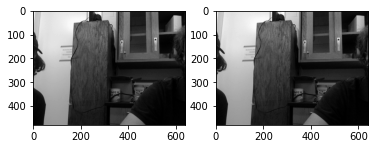

In [ ]:



frame_a  = tools.imread( background )
frame_b  = tools.imread( foregroung )


print (frame_a)
print (frame_b)


fig,ax = plt.subplots(1,2)
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)



winsize = 24 # pixels
searchsize = winsize*3  # pixels, search in image B
overlap = int(winsize)/2 # pixels
dt = 0.02 # sec


u0, v0, sig2noise = process.extended_search_area_piv( frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=winsize, overlap=overlap, dt=dt, search_area_size=searchsize, sig2noise_method='peak2peak' )

x, y = process.get_coordinates( image_size=frame_a.shape, window_size=winsize, overlap=overlap )


In [ ]:

u1, v1, mask = validation.sig2noise_val( u0, v0, sig2noise, threshold = 1.3 )


u2, v2 = filters.replace_outliers( u1, v1, method='localmean', max_iter=10, kernel_size=2)

x, y, u3, v3 = scaling.uniform(x, y, u2, v2, scaling_factor = 10)


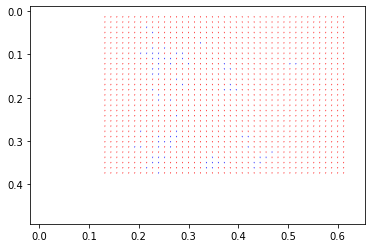

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4fa6b6b710>)

In [ ]:

tools.save(x, y, u3, v3, mask, 'exp1_001.txt' )

tools.display_vector_field('exp1_001.txt', scale=100, width=0.005)

In [ ]:
# I have no idea who is the author of the code
# in this cell that saves an image from a webcam
# inside google colab.
# It comes from a notebook called "📸 Take a photo with your webcam"

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<div class="video_container">
  <video autoplay
   width=%d height=%d></video>
  <div style='position: absolute;top: 40px; left: 40px; font-size: 40px; color: green;'>Click to save!</div>
</div>
<script>
var video = document.querySelector('video')
navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""

def take_photo(filename=None, quality=0.8, size=(800,600)):
  handle = display(HTML(VIDEO_HTML % (size[0],size[1],quality)), display_id='videoHTML')
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  if filename:
    f = io.BytesIO(binary)
    Image.open(f).save(filename)
  else:
    f = io.BytesIO(binary)
    return np.asarray(Image.open(f))

In [ ]:
photo = take_photo( quality=0.8, size=(1000,1000))

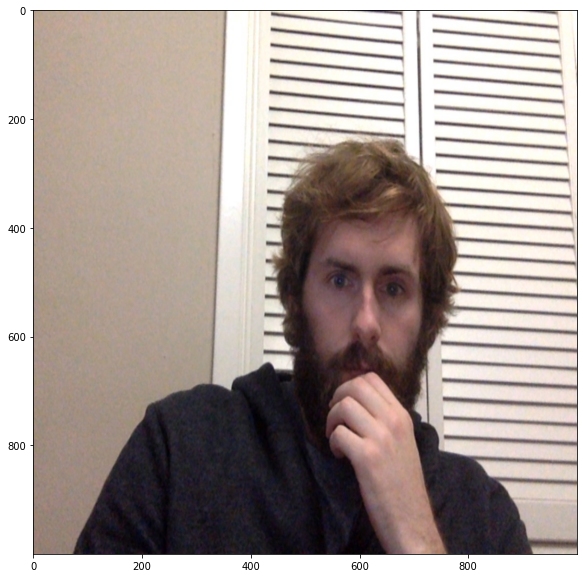

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(photo)
plt.show()

In [ ]:
import cv2

camera = cv2.VideoCapture(0)
i = 0
while i < 10:
    raw_input('Press Enter to capture')
    return_value, image = camera.read()
    cv2.imwrite('opencv'+str(i)+'.png', image)
    i += 1
del(camera)

NameError: ignored

In [ ]:
image